# 편향과 분산
<img src='https://images.unsplash.com/photo-1603123854557-1fbbdd6b4bb3?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxzZWFyY2h8M3x8c3RyaWd0aCUyMG9yJTIwdnVydmV8ZW58MHx8MHx8&auto=format&fit=crop&w=500&q=60'>

In [2]:
from IPython.core.interactiveshell import InteractiveShell # 모든 명령어 출력
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')

from mlxtend.evaluate import bias_variance_decomp
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from mlxtend.data import boston_housing_data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor

# 1. bias-variance-decomposition 
https://towardsdatascience.com/bias-variance-decomposition-d0e22d1506b1

In [3]:
def get_bias_var(tree, X_train, y_train, X_test, y_test, loss_type):
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(tree, X_train, y_train, X_test, y_test, loss=loss_type, random_seed=123)

    print('Average expected loss: %.3f' % avg_expected_loss)
    print('Average bias: %.3f' % avg_bias)
    print('Average variance: %.3f' % avg_var)
    return

## Pruning DT reduces the variance
### tree vs. tree_pruned의 편향과 분산

In [4]:
X, y = boston_housing_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, shuffle=True)

tree = DecisionTreeRegressor(random_state=123)
error_dt, bias_dt, var_dt = bias_variance_decomp(tree, X_train, y_train, X_test, y_test,'mse', random_seed=123)

tree_pruned = DecisionTreeRegressor(random_state=123, max_depth=2)
error_dt_pruned, bias_dt_pruned, var_dt_pruned = bias_variance_decomp(tree_pruned, X_train, y_train, X_test, y_test,'mse', random_seed=123)

print("variance Reduction:", str(np.round((var_dt_pruned/var_dt-1)*100,2)) + '%')
print("At the expense of introducing bias:", str(np.round((bias_dt_pruned/bias_dt-1)*100, 2)) + '%')

variance Reduction: -61.1%
At the expense of introducing bias: 112.98%


## Using Ensemble/Random Forest to reduce variance

In [5]:
tree = DecisionTreeRegressor(random_state=123)
error_dt, bias_dt, var_dt = bias_variance_decomp(tree, X_train, y_train, X_test, y_test,'mse', random_seed=123)

tree_rf = RandomForestRegressor(random_state=123)
error_rf, bias_rf, var_rf = bias_variance_decomp(tree_rf, X_train, y_train, X_test, y_test,'mse', random_seed=123)

print("variance Reduction:", str(np.round((var_rf/var_dt-1)*100,2))+ '%')
print("At the expense of introducing bias:", str(np.round((bias_rf/bias_dt-1)*100, 2)) + '%')

variance Reduction: -82.0%
At the expense of introducing bias: 9.24%


## KNN -- a high value of k leads to high bias and low variance

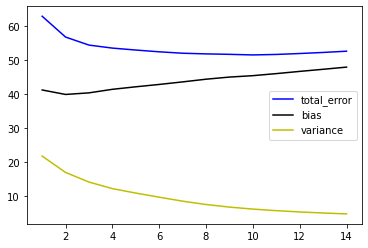

In [9]:
bias_knn, var_knn, error_knn = [], [], []

for k in range(1, 15):
    clf_knn = KNeighborsRegressor(n_neighbors=k)
    avg_expected_loss, avg_bias, avg_var  = avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(clf_knn, X_train, y_train, X_test, y_test, loss='mse', random_seed=123)
    bias_knn.append(avg_bias)
    var_knn.append(avg_var)
    error_knn.append(avg_expected_loss)
plt.plot(range(1,15), error_knn, 'b', label = 'total_error')
plt.plot(range(1,15), bias_knn, 'k', label = 'bias')
plt.plot(range(1,15), var_knn, 'y', label = 'variance')
plt.legend()

## Adding features bring down the bias

DecisionTreeRegressor(random_state=123)

Top 6 features controbute 95% of total feature importance: 0.959406219367535


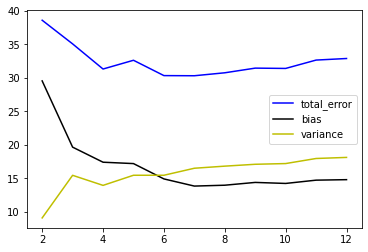

In [10]:
tree = DecisionTreeRegressor(random_state=123)
tree.fit(X_train, y_train)
feat_array = tree.feature_importances_

df_feat = pd.DataFrame()
name_list, importance_list = [], []

for name, importance in zip(range(X_train.shape[1]), feat_array):
    name_list.append(name)
    importance_list.append(importance)
df_feat['name'] = name_list
df_feat['importance'] = importance_list

print("Top 6 features controbute 95% of total feature importance:", df_feat.sort_values(by = 'importance', ascending = False).head(6)['importance'].sum())

error_fs, bias_fs, var_fs  = [], [], []
feat_count = [2,3,4,5,6,7,8,9,10,11,12]
for feat in feat_count:
    top_feat = df_feat.sort_values(by = 'importance', ascending = False).head(feat)['name'].values
    X_train_fs = X_train[:, top_feat]
    X_test_fs = X_test[:, top_feat]
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(tree, X_train_fs, y_train, X_test_fs, y_test, loss='mse', random_seed=123)
    error_fs.append(avg_expected_loss)
    bias_fs.append(avg_bias)
    var_fs.append(avg_var)
    
plt.plot(feat_count, error_fs, 'b', label = 'total_error')
plt.plot(feat_count, bias_fs, 'k', label = 'bias')
plt.plot(feat_count, var_fs, 'y', label = 'variance')
plt.legend()

## Regularization to control the variance

In [11]:
linear_model = LinearRegression()
lasso_model = Lasso(alpha=0.05)
error_reg, bias_reg, var_reg = bias_variance_decomp(lasso_model, X_train, y_train, X_test, y_test, loss='mse', random_seed=123)
error_no_reg, bias_no_reg, var_no_reg = bias_variance_decomp(linear_model, X_train, y_train, X_test, y_test, loss='mse', random_seed=123)
print("variance Reduction:", (var_reg/var_no_reg-1)*100)
print("At the expense of introducing bias:", (bias_reg/bias_no_reg-1)*100)

variance Reduction: -8.300876521565936
At the expense of introducing bias: 5.913326786791506


# 2. Bias-Variance Decomposition for Model Assessment
### Bias-variance decomposition of machine learning algorithms with a hands-on example in Python
https://towardsdatascience.com/bias-and-variance-for-model-assessment-a2edb69d097f

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from mlxtend.evaluate import bias_variance_decomp
from mlxtend.data import boston_housing_data

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

np.random.seed(16)
tf.random.set_seed(16)

In [15]:
X, y = boston_housing_data()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    shuffle=True)

## Example 1: Decision tree

In [22]:
tree = DecisionTreeRegressor(random_state=16)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        tree, X_train, y_train, X_test, y_test, 
        loss='mse',
        random_seed=16)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 32.419
Average bias: 14.197
Average variance: 18.222


In [23]:
tree = DecisionTreeRegressor(random_state=16)
bag = BaggingRegressor(base_estimator=tree,
                       n_estimators=100,
                       random_state=16)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        bag, X_train, y_train, X_test, y_test, 
        loss='mse',
        random_seed=16)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 18.693
Average bias: 15.291
Average variance: 3.402


## Example 2: Neural network

In [24]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

optimizer = tf.keras.optimizers.Adam()
model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
mean_squared_error(model.predict(X_test), y_test)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        model, X_train, y_train, X_test, y_test, 
        loss='mse',
        num_rounds=100,
        random_seed=16,
        epochs=100,
        batch_size=32,
        verbose=0)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

25.512323307640344

Average expected loss: 25.302
Average bias: 19.623
Average variance: 5.680


In [27]:
pwd

'D:\\deep learning'

In [26]:
model = Sequential()
model.add(Dense(800, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

optimizer = tf.keras.optimizers.Adam()
model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
mean_squared_error(model.predict(X_test), y_test)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        model, X_train, y_train, X_test, y_test, 
        loss='mse',
        num_rounds=100,
        random_seed=16,
        epochs=100,
        batch_size=32,
        verbose=0)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

24.186171805289003

Average expected loss: 25.508
Average bias: 19.426
Average variance: 6.081


# End